# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [73]:
import io
import os
import numpy as np
import scipy

In [74]:
PATH_TO_DATA = "/Users/jennifervial/Desktop/nlp_project/data/"

# 1) Monolingual (English) word embeddings 

In [75]:
#Let's define our words vectors
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = dict.fromkeys(self.word2vec.keys())
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())  
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
            
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        scrs = []
        idc = []
        for v in self.word2id:
            scrs.append(self.score(w,v))
            idc.append(v)# K most similar words: self.score  -  np.argsort 
        s = np.argsort(scrs)
        f_s = []
        
        for i in range(4):
            f_s.append(idc[s[-i-1]])
        
        
        return f_s[:4]

    def score(self, w1, w2):
        #cosine similarity: np.dot  -  np.linalg.norm
        #Returns the similarity score of two words
        #Both words must be in the dictionary
        
        word_idx1 = self.word2vec[w1]
        word_idx2 = self.word2vec[w2]
        
        dst = np.dot(word_idx1,word_idx2) / (np.linalg.norm(word_idx1) * np.linalg.norm(word_idx2))

            
        return dst

In [76]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=100000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w1, w2v.most_similar(w1))

Loaded 100000 pretrained word vectors
cat dog 0.6716836662792491
dog pet 0.6842064029669219
dogs cats 0.7074389328052404
paris france 0.7775108541288561
germany berlin 0.7420295235998392
cat ['cat', 'cats', 'kitty', 'kitten']
dog ['dog', 'dogs', 'puppy', 'Dog']
dogs ['dogs', 'dog', 'pooches', 'Dogs']
paris ['paris', 'france', 'Paris', 'london']
germany ['germany', 'austria', 'europe', 'german']


#### Build our Bag of Words class:

In [77]:
#Let's define our bag of words vectors: 
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v

#Let's encode our list of sentences: make them numpy array of sentence embeddings:
    def encode(self, sentences, idf=False, fill_blank=False):
       
        sentemb = []
        for sent in sentences:
            if idf is False:
                encod = [w2v.word2vec[w] for w in sent if w in w2v.word2vec]   #Let's look for the words embedings thanks to the function define above. 
                if encod != []:
                    sentemb.append(np.mean(encod, axis = 0)) #If the words do exist in our dictionnary we can compute the sentence embeding by taking the mean of all the words embeding. 
            
                else:
                    sentemb.append([0]*300) #If the words are not in the dictionnary we assign the value 300. 
               
                
            else:
                encod = [w2v.word2vec[w]*idf[w] for w in sent if w in w2v.word2vec and w in idf]
                if encod != []:
                    sentemb.append(np.mean(encod, axis = 0))
                else:
                    sentemb.append([0]*300)
                # idf-weighted mean of word vectors
                #sentemb.append(np.mean([w2v.word2vec[w]*idf[w] for w in sent if w in w2v.word2vec and w in idf], axis=0))
                #assert False, 'TODO: fill in the blank'
        
        sentemb_np_array = np.asarray(sentemb)
        
        return np.vstack(sentemb_np_array)
    
#Let's define the function to get the most similar sentences:        
    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        index_sent = sentences.index(s)
        
        #Let's ncode all the sentences and retrieve the vector of the target sentence
        keys = self.encode(sentences, idf)
        query = keys[sentences.index(s),]  
        
        ##Let's normalize embeddings with np.linalg.norm
        keys = keys / np.linalg.norm(keys, 2, 1)[:, None]  
        query = query/np.linalg.norm(query)
           
        #Let's compute score with other sentences vector for s            
        scores = np.dot(keys,query) 
        indx = scores.argsort()[::-1][1:K+1]
        
        #Let's select the K  most important score based on the most similar sentences
        sentences_similar = []
        scores_similar = []
        
        for i in indx:
            sentences_similar.append(sentences[i])
            scores_similar.append(scores[i])
             
        return  print( 'For ',s, ', the ',K,' most similar sentences are: \n',sentences_similar,',\n With respective similarities: \n',scores_similar)

   
    #Let's define our score function to assess the similarity between sentences
    def score(self, s1, s2, idf=False):
    
        #Let's compute the sentence embeding matrix
        sentemb = self.encode(sentences,idf)
        
        #Let's encode the sentence we aim at comparing (s1 and s2)
        s1_encod = sentemb[sentences.index(s1)]
        s2_encod = sentemb[sentences.index(s2)]
        
        #Let's normalize s1 and s2 to do the dot product with np.linalg.norm
        s1_normalized = np.linalg.norm(s1_encod)
        s2_normalized = np.linalg.norm(s2_encod)
        
        # The cosine similarity is the dot-product of normalized vector 
        s = np.dot(s1_encod,s2_encod)/float(s1_normalized*s2_normalized)
       
        return print('The similarity score between \n',s1,'\n and ',s2,'\n is up to ',s,'\n')

    
   #Let's define our function to build the idf 
    def build_idf(self,sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {} 

        for sent in sentences:
                for w in set(sent): #set() gives unique elements in list 
                    idf[w] = idf.get(w, 0) + 1

        for w in idf:
            idf[w] = max(1,(np.log10(len(sentences) / (idf[w]))))
            
        return idf

#### Try our Bag of Words class:

In [78]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=5000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
sentences = open("/Users/jennifervial/Desktop/nlp_project/data/sentences.txt").read().split("\n")

# Build idf scores for each word
idf = {} if True else s2v.build_idf(sentences)

# You will be evaluated on the output of the following:
s2v.most_similar('' if not sentences else sentences[10], sentences)  # BoV-mean
s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13])


idf = {}  
s2v.most_similar('' if not sentences else sentences[10], sentences, idf)  # BoV-idf
s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf)

Loaded 5000 pretrained word vectors


/Users/jennifervial/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


For  1 smiling african american boy .  , the  5  most similar sentences are: 
 ['1 smiling african american boy . ', 'an african american male is singing into a microphone . ', 'an african american man is jumping in the air , while a boy claps . ', 'a man rock climbing in a forest . ', 'a man on a bmx bike is performing a trick . '] ,
 With respective similarities: 
 [0.9999999999999998, 0.9937266333785353, 0.9937227698276595, 0.993666741913605, 0.9933661492388244]
The similarity score between 
 1 man singing and 1 man playing a saxophone in a concert .  
 and  10 people venture out to go crosscountry skiing .  
 is up to  0.9554053961582658 



/Users/jennifervial/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


For  1 smiling african american boy .  , the  5  most similar sentences are: 
 ['a man spinning a skateboard in his hands while people watch . ', 'a man squatted at an outdoor campfire cooking food and smiling . ', 'a man squats near a fire and holds something into it . ', 'a man squats in the grass to take a picture of a flower while a slim woman looks on . ', 'a man sprinkling the corn on the ground . '] ,
 With respective similarities: 
 [nan, nan, nan, nan, nan]
The similarity score between 
 1 man singing and 1 man playing a saxophone in a concert .  
 and  10 people venture out to go crosscountry skiing .  
 is up to  nan 



/Users/jennifervial/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [79]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

#Use Word2vec function defined above to load our French vectors:
FR=Word2vec('/Users/jennifervial/Downloads/wiki.fr.vec', nmax=50000)
#Use Word2vec function defined above to load our French vectors:
EN=Word2vec('/Users/jennifervial/Downloads/wiki.en.vec', nmax=50000)


Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors


In [80]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

both_vocabs_words =[w for w in EN.word2vec if w in FR.word2vec ]

#Let's define X, the Matrix with French words 
X = np.vstack([FR.word2vec[w] for w in both_vocabs_words])
#Let's define Y, the Matrix with English words
Y = np.vstack([EN.word2vec[w] for w in both_vocabs_words])


In [81]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

#Computation of the product Y.X^T with np.dot
import numpy as np 
a=np.dot(X.transpose(),Y)

# Computation of SVD(Y.X^T) with np.linalg.svd
import numpy as np
U, S, V_t= np.linalg.svd(a)

#Computation of W = U.V^T
W=np.dot(U,V_t)

#Computation of W*French_vector with np.dot 
New_French_vector=np.dot(list(FR.word2vec.values()),W)

In [87]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

# Let's fill the french dictionary with New_French_vector created question 3
fr_tr = dict()
fr_word = list(FR.word2vec.keys())
for i in range(len(New_French_vector)):
    fr_tr[fr_word[i]] = New_French_vector[i]

#Let's try to translate the words: 'chat', 'chaton', 'chienne', 'france', 'berlin' from French to English though cosine similarity    
#Print the result from the most likely to the least (4 results)
for w in ['chat', 'chaton', 'chienne', 'france', 'berlin']:
    scores = {}
    for word in EN.word2vec.keys():
        v1 = fr_tr[w]
        v2 = EN.word2vec[word]
        scores[word] = np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
    print(sorted(scores, key=scores.get, reverse=True)[0:4])  

#Let's try to translate the words: 'shirt', 'dogs', 'house', 'country', 'paris' from English to French though cosine similarity    
#Print the result from the most likely to the least (4 results)
for w in ['shirt', 'dogs', 'house', 'country', 'paris']:
    scores = {}
    for word in fr_tr.keys():
        v1 = EN.word2vec[w]
        v2 = fr_tr[word]
        scores[word] = np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
    print(sorted(scores, key=scores.get, reverse=True)[0:4])



['cat', 'rabbit', 'hamster', 'feline']
['kittens', 'kitten', 'puppy', 'fluffy']
['dog', 'poodle', 'kittens', 'puppies']
['france', 'auvergne', 'luxembourg', 'french']
['berlin', 'munich', 'leipzig', 'hamburg']
['shirt', 'maillots', 'shirts', 'pantalon']
['chiens', 'dogs', 'chats', 'dog']
['house', 'maison', 'houses', 'room']
['country', 'countries', 'swaziland', 'pays']
['paris', 'parisienne', 'lyon', 'versailles']


We can see through the results that our algorithm manage to find the good translation in the first 2 words for everycase eventhough there can be some mistakes in the rest of the words the lexical remains really close. 

If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [88]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

PATH_TO_SST = "/Users/jennifervial/Downloads/nlp_project/data/SST/"


#Let's load our sentences
def load(path, label_cut=False):
    labels = []
    sentences = []
    with open(path, encoding="utf8") as f:
        for line in f:
            
            if label_cut == False:
                label, line = line.split(' ', 1)
                labels.append(label)
                
            sentences.append(line.split())
    return labels, sentences

#Load the training data
Y_train , X_train = load(os.path.join(PATH_TO_SST,'stsa.fine.train'), label_cut = False)

#Load the dev data 
Y_dev , X_dev = load(os.path.join(PATH_TO_SST,'stsa.fine.dev'), label_cut = False)

#Load the testing data
Y_test , X_test = load(os.path.join(PATH_TO_SST,'stsa.fine.test.X'), label_cut = True)

In [91]:
# 2 - Encode sentences with the BoV model above

#Model without the idf weights with s2v
idfq3 = {}
Wtrain = s2v.encode(X_train)
Wdev = s2v.encode(X_dev)
Wtest = s2v.encode(X_test)

#Let's generate the idf weights for encoding function
idfq3 = s2v.build_idf(X_train)
Wtrain_idf = s2v.encode(X_train ,idfq3)
Wdev_idf = s2v.encode(X_dev, idfq3)
Wtest_idf = s2v.encode(X_test, idfq3)

In [92]:
#Import our packages to realise the Logistic Regression 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [98]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)


#Let's define  our logistic regression function
logiregr = LogisticRegression(penalty = 'l2',C=5)

#Generate Cross validation results on training set with the BoV mean model
Cross_Val_mean = cross_val_score(logiregr,Wtrain,Y_train,cv=5)

print('The results for Simple LogisticRegression with the BoV-mean model \nCV (=5)  \n',Cross_Val_mean)
print('The Cross Validation results mean are equal to',np.mean(Cross_Val_mean))

#Let's test with the dev set with BoV mean model
logiregr.fit(Wtrain,Y_train)

print('\n The Cross Validation results on the dev sets are equal to ',logit.score(Wdev, Y_dev),'\n')

#Generate Cross validation results on training set with the BoV idf weight model
Cross_Val_idf = cross_val_score(logiregr,Wtrain_idf,Y_train,cv=5)

print('The results for Simple LogisticRegression with the BoV idf model \nCV (=5)  \n',Cross_Val_idf)
print('The Cross Validation results idf are equal to ',np.mean(CV_Scr_idf))

#Test with dev set with BoV idf model
logiregr.fit(Wtrain_idf,Y_train)

print('\nCV results on dev sets = ',logiregr.score(Wdev_idf, Y_dev),'\n')

The results for Simple LogisticRegression with the BoV-mean model 
CV (=5)  
 [0.38047925 0.37580362 0.37331773 0.37141183 0.37221571]
The Cross Validation results mean is equal to 0.3746456296131087

CV results on dev sets =  0.36693914623069934 

BoV-idf model 
CV (=5) results for Simple LogisticRegression 
 [0.36060783 0.36820573 0.35517847 0.36438196 0.36049238]
CV results mean =  0.36177327254934605

CV results on dev sets =  0.3651226158038147 



In [99]:
#Import Packaging to tune our Logistic Regression
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import StratifiedKFold

In [49]:
# turn gs to True if you want to run the gridsearch again.
gs = True

#Make the gride seach on the logistic regression 
if gs:
    parameters_grid = {
                 'C': [0.001, 0.01, 0.1, 1, 5, 10, 100, 1000]
                 }
    logiregr = LogisticRegression()
    crossvalidation = StratifiedKFold(Y_train, n_folds=5)

    gridsearch = GridSearchCV(lr,
                               scoring='accuracy',
                               param_grid=parameters_grid,
                               cv=crossvalidation)

    gridsearch.fit(Wtrain, Y_train)
    logiregr_best = gridsearch
    parameters = gridsearch.best_params_

    print('The best score is {}'.format(gridsearch.best_score_))
    print('The best parameters are {}'.format(gridsearch.best_params_))
else: 
    parameters = {'C': 1.0}
    
    logiregr_best = LogisticRegression(**parameters)
    logiregr_best.fit(Wtrain, Y_train)
    
print(logiregr_best.score(Wdev,Y_dev))

/Users/jennifervial/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Best score: 0.3838951310861423
Best parameters: {'C': 1}
0.38419618528610355


In [50]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.


Y_pred_test = logit.predict(W_test)

text_file = open("logreg_bov_y_test_sst.txt", "w")
text_file.write('\n'.join(Y_pred_test))
text_file.close()

In [51]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# TYPE CODE HERE

# Support Vector Machines

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()

# Dev test 

CV_score = cross_val_score(clf,W_train,Y_train,cv=5)
print('BoV-mean model \nCV results for SVM',CV_score)
print('CV mean = ', np.mean(CV_score),'\n')
clf.fit(W_train,Y_train)
print('CV results on dev sets =',clf.score(W_dev, Y_dev),'\n')

CV_score_idf = cross_val_score(clf,W_train_idf,Y_train,cv=5)
print('BoV-idf model \nCV results for SVM',CV_score_idf)
print('CV mean = ', np.mean(CV_score_idf),'\n')
clf.fit(W_train_idf,Y_train)
print('CV results on dev sets =',clf.score(W_dev_idf, Y_dev),'\n')

BoV-mean model 
CV results for SVM [0.33138515 0.32963179 0.32358104 0.33099004 0.34114889]
CV mean =  0.3313473835977251 

CV results on dev sets = 0.34150772025431425 

BoV-idf model 
CV results for SVM [0.29982466 0.31560491 0.27794032 0.31927358 0.30363423]
CV mean =  0.3032555401648246 

CV results on dev sets = 0.335149863760218 



# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [53]:
import keras

/Users/jennifervial/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [54]:
# 1 - Load train/dev/test sets of SST

PATH_TO_SST = "/Users/jennifervial/Downloads/nlp_project/data/SST/"

#Load the sentences like in the 1st exercise
def load_texts(path, label_cut=False):
    labels = []
    sentences = []
    with open(path, encoding="utf8") as f:
        for line in f:
            if label_cut == False:
                label, line = line.split(' ', 1)
                labels.append(label)
            sentences.append(line.split())
    return labels, sentences

#Load labeled data
Y_train , X_train = load_texts(os.path.join(PATH_TO_SST,'stsa.fine.train'), label_cut = False)
Y_dev , X_dev = load_texts(os.path.join(PATH_TO_SST,'stsa.fine.dev'), label_cut = False)

#Load non-labeled data
Y_test , X_test = load_texts(os.path.join(PATH_TO_SST,'stsa.fine.test.X'), label_cut = True)


from keras.utils import to_categorical
Y_train = to_categorical(Y_train,5)
Y_dev = to_categorical(Y_dev,5)

In [55]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

#from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import one_hot

def text_to_integers(text, size):
    output=[]
    for sent in text:
        sent = str(sent)
        new = keras.preprocessing.text.one_hot(sent, 
                                    size,
                                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                     lower=True,
                                     split=" ")
        output.append(new)
    return output

size_voc = 16000
X_train_processed = text_to_integers(X_train, size_voc)
X_dev_processed = text_to_integers(X_dev, size_voc)
X_test_processed = text_to_integers(X_test, size_voc)

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [56]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# TYPE CODE HERE

from keras.preprocessing.sequence import pad_sequences

X_train_4 = pad_sequences(X_train_processed)
X_dev_4 = pad_sequences(X_dev_processed)
X_test_4 =pad_sequences(X_test_processed)

print(len(X_train_4[0]))


67


## 4.2 - Design and train your model

In [57]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW


from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 2000  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = size_voc  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout_W=0.2, dropout_U=0.2))
model.add(Dense(n_classes, activation='softmax'))


/Users/jennifervial/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, dropout=0.2, recurrent_dropout=0.2)`


In [58]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'rmsprop' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 2000)        32000000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                528640    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 32,528,965
Trainable params: 32,528,965
Non-trainable params: 0
_________________________________________________________________
None


In [59]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW
bs = 64
n_epochs = 4

LSTM = model.fit(X_train_4, Y_train, batch_size=bs, nb_epoch=n_epochs, validation_data=(X_dev_4, Y_dev))


/Users/jennifervial/anaconda3/lib/python3.6/site-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 8544 samples, validate on 1101 samples
Epoch 1/4
8544/8544 [==============================] - 209s 24ms/step - loss: 1.4930 - acc: 0.3343 - val_loss: 1.3961 - val_acc: 0.3869
Epoch 2/4
8544/8544 [==============================] - 206s 24ms/step - loss: 1.1951 - acc: 0.4949 - val_loss: 1.4131 - val_acc: 0.3987
Epoch 3/4
8544/8544 [==============================] - 205s 24ms/step - loss: 0.9314 - acc: 0.6362 - val_loss: 1.5478 - val_acc: 0.3697
Epoch 4/4
8544/8544 [==============================] - 201s 24ms/step - loss: 0.6815 - acc: 0.7468 - val_loss: 1.7900 - val_acc: 0.3778


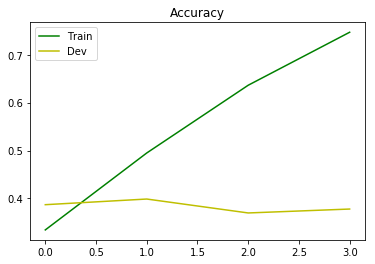

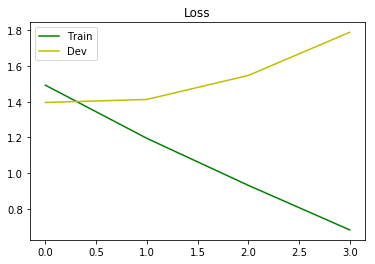

In [60]:
#Plot the evolution of train/dev results w.r.t the number of epochs
from matplotlib import pyplot as plt


plt.title("Accuracy")
plt.plot(LSTM.history["acc"], color="g", label="Train")
plt.plot(LSTM.history["val_acc"], color="y", label="Dev")
plt.legend(loc="best")
plt.show()

plt.title("Loss")
plt.plot(LSTM.history["loss"], color="g", label="Train")
plt.plot(LSTM.history["val_loss"], color="y", label="Dev")
plt.legend(loc="best")
plt.show()

In [61]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

Y_test_pred = model.predict(X_test_4)
Y_pred = []


for i in range(Y_test_pred.shape[0]):
    index_max = list(Y_test_pred[i]).index(max(Y_test_pred[i]))
    Y_pred.append(str(index_max))
Y_pred = np.asarray(Y_pred)

#create file with predictions
output_file = open("logreg_lstm_y_test_sst.txt.txt",'w')
output_file.write('\n'.join(Y_pred))
output_file.close()

#print(Y_test_pred[2])


## 4.3 -- innovate !

In [62]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 2000  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = size_voc  # size of the vocabulary
n_classes  = 5

model2 = Sequential()

model2.add(Embedding(vocab_size, embed_dim))

model2.add(LSTM(nhid, dropout_W=0.2, dropout_U=0.2))

model2.add(Dense(n_classes, activation='softmax'))


loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'Adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model2.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model2.summary())

bs = 64
n_epochs = 4

LSTM = model2.fit(X_train_4, Y_train, batch_size=bs, nb_epoch=n_epochs, validation_data=(X_dev_4, Y_dev))


/Users/jennifervial/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, dropout=0.2, recurrent_dropout=0.2)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 2000)        32000000  
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                528640    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 32,528,965
Trainable params: 32,528,965
Non-trainable params: 0
_________________________________________________________________
None


/Users/jennifervial/anaconda3/lib/python3.6/site-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 8544 samples, validate on 1101 samples
Epoch 1/4
8544/8544 [==============================] - 239s 28ms/step - loss: 1.5094 - acc: 0.3173 - val_loss: 1.4086 - val_acc: 0.3915
Epoch 2/4
8544/8544 [==============================] - 191s 22ms/step - loss: 1.1531 - acc: 0.5214 - val_loss: 1.4747 - val_acc: 0.3733
Epoch 3/4
8544/8544 [==============================] - 189s 22ms/step - loss: 0.6998 - acc: 0.7425 - val_loss: 1.7331 - val_acc: 0.3688
Epoch 4/4
8544/8544 [==============================] - 210s 25ms/step - loss: 0.3657 - acc: 0.8755 - val_loss: 2.2180 - val_acc: 0.3678
